# Surface map of METAR data

## Table of Contents <a class="anchor" id="top"></a>

* [Objective](#objective)
* [Strategy](#strategy)
* [Step 0: Import required packages](#step0)
* [Step 1: Browse a THREDDS Data Server (TDS)](#step1)
* [Step 2: Determine the date and hour to gather observations](#step2)
* [Step 3: Surface observations](#step3)
    * [Step 3a: Determine catalog location for Surface observations](#step3a)
    * [Step 3b: Subset Surface observations](#step3b)    
    * [Step 3c: Retrieve Surface observations](#step3c)
    * [Step 3d: Process Surface observations](#step3d)
    * [Step 3e: Visualize Surface observations](#step3e)

## Objective
> In this notebook, we will make a surface map based on current observations from METAR sites across North America.

## Step 0: Import required packages <a class="anchor" id="step0"></a>
[Top](#top)
> But first, we need to import all our required packages. Today we're working with:
> - datetime
> - numpy
> - pandas
> - matplotlib
> - cartopy
> - metpy
> - siphon

> We will also import a couple of functions that convert weather and cloud cover symbols from METAR files encoded in GEMPAK format.

In [1]:
from datetime import datetime,timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from metpy.calc import wind_components, reduce_point_density
from metpy.units import units
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [2]:
# Load in a collection of functions that process GEMPAK weather conditions and cloud cover data.
%run /kt11/ktyle/python/metargem.py

## Step 1: Browse a THREDDS Data Server (TDS) <a class="anchor" id="step1"></a>
[Top](#top)

> A **THREDDS Data Server** provides us with coherent access to a large collection of real-time and archived datasets from a variety of environmental data sources at a number of distributed server sites. 
> Various institutions serve data via THREDDS, including our department. You can browse our department's TDS in your web browser using this link: 

<a href="http://thredds.atmos.albany.edu:8080/thredds" target ="blank">http://thredds.atmos.albany.edu:8080/thredds</a>


> Let's take a few moments to browse the catalog in a new tab of your web browser.

## Step 2: Determine the date and hour to gather observations <a class="anchor" id="step2"></a>

In [100]:
# Use the current time, or set your own for a past time.
# Set current to False if you want to specify a past time.

nowTime = datetime.utcnow()
current = False
#current = False
if (current):
    validTime = datetime.utcnow()
    year = validTime.year
    month = validTime.month
    day = validTime.day
    hour = validTime.hour
else:
    year = 2013
    month = 5
    day = 20
    hour = 23
    
validTime = datetime(year, month, day, hour)
deltaTime = nowTime - validTime
deltaDays = deltaTime.days
timeStr = validTime.strftime("%Y-%m-%d %H UTC")
timeStr2 = validTime.strftime("%Y%m%d%H")

print(timeStr)
print(validTime)
print(deltaTime)
print(deltaDays)

2013-05-20 23 UTC
2013-05-20 23:00:00
3634 days, 19:32:47.617108
3634


## Step 3: Surface observations <a class="anchor" id="step3"></a>

### Step 3a:  Determine catalog location for Surface observations <a class="anchor" id="step3a"></a>
[Top](#top)

If the date is within the past week, use the current METAR data catalog.
Otherwise, use the archive METAR data catalog.

In [101]:
if (deltaDays <= 7):
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecodedNAm/catalog.xml?dataset=metar/ncdecodedNAm/Metar_NAm_Station_Data_fc.cdmr'
else:
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Note:</p>
    Our METAR archive goes back to April 2019. Requests for older dates may fail. If you need data for an earlier date, email Ross or Kevin.
</div>

In [102]:
# Create a TDS catalog object from the URL we created above, and examine it.
# The .cdmr extension represents a dataset that works especially well with irregularly-spaced point data sources, such as METAR sites.

catalog = TDSCatalog(metar_cat_url)
catalog

Feature Collection

In [103]:
# This tells us that there is only one dataset type within this catalog, namely a Feature Collection. We now create an object to store this dataset.
metar_dataset = catalog.datasets['Feature Collection']

#### This dataset consists of multiple hours and locations. We are only interested in a subset of this dataset; for example, the most recent hour, and sites within a geographic domain that we will define below. For this, we will exploit a feature of THREDDS that allows for easy subsetting ... the NetCDF Subset Service (NCSS). 

In [104]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']
print(ncss_url)
# Import ncss client
ncss = NCSS(ncss_url)

http://thredds.atmos.albany.edu:8080/thredds/ncss/metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr


One of the `ncss` object's attributes is `variables`. Let's look at that:

In [105]:
ncss.variables

{'ALTI',
 'CEIL',
 'CHC1',
 'CHC2',
 'CHC3',
 'COUN',
 'CTYH',
 'CTYL',
 'CTYM',
 'DRCT',
 'DWPC',
 'GUST',
 'MSUN',
 'P01I',
 'P03C',
 'P03D',
 'P03I',
 'P06I',
 'P24I',
 'PMSL',
 'SKNT',
 'SNEW',
 'SNOW',
 'SPRI',
 'STAT',
 'STD2',
 'STNM',
 'T6NC',
 'T6XC',
 'TDNC',
 'TDXC',
 'TMPC',
 'VSBY',
 'WEQS',
 'WNUM',
 '_isMissing'}

These are abbreviations that the GEMPAK data analysis/visualization package uses for all the meteorological data potentially encoded into a METAR observation.

### Step 3b: Subset Surface Observations <a class="anchor" id="step3b"></a>
[Top](#top)

#### Now, let's request all stations within a bounding box for a given time, select certain variables, and create a surface station plot
 * Make new NCSS query that specifies a regional domain and a particular time.
 * Request data closest to "now", or specify a specific YYMMDDHH yourself.
 * Specify what variables to retreive


In [106]:
# Set the domain to gather data from and for defining the plot region.
latN = 40
latS = 32
lonW = -105
lonE = -90
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

### Step 3c: Retrieve Surface Observations <a class="anchor" id="step3c"></a>
[Top](#top)

Create an object to build our data query

In [107]:
query = ncss.query()

query.lonlat_box(north=latN-.25, south=latS+0.5, east=lonE-.25, west=lonW+.25)

# We actually specify a time one minute earlier than the specified hour; this is a quirk of how the data is stored on the THREDDS server and ensures we will get data
# corresponding to the hour we specified
query.time(validTime - timedelta(minutes = 1))

# Select the variables to query.  Note that the variable names depend on the source of the METAR data.
# The 'GEMPAK-like' 4-character names are from the UAlbany THREDDS.

query.variables('TMPC', 'DWPC', 'PMSL',
                'SKNT', 'DRCT','ALTI','WNUM','VSBY','CHC1', 'CHC2', 'CHC3','CTYH', 'CTYM', 'CTYL' )
query.accept('csv')

var=CHC3&var=CHC2&var=VSBY&var=PMSL&var=CTYH&var=DRCT&var=CTYL&var=SKNT&var=TMPC&var=CHC1&var=ALTI&var=WNUM&var=CTYM&var=DWPC&time=2013-05-20T22%3A59%3A00&west=-104.75&east=-90.25&south=32.5&north=39.75&accept=csv

Pass the query to the THREDDS server's NCSS service. We can then create a Pandas `dataframe` from the returned object.

In [108]:
data = ncss.get_data(query)
df = pd.DataFrame(data)
df

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/siphon/ncss.py:432: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arrs = np.genfromtxt(fobj, dtype=None, names=names, delimiter=',',


,time,station,latitude,longitude,CHC3,CHC2,VSBY,PMSL,CTYH,DRCT,CTYL,SKNT,TMPC,CHC1,ALTI,WNUM,CTYM,DWPC
0,b'2013-05-20T23:00:00Z',b'GLH',33.479,-90.980,NaN,603.0,10.0,1010.80000,NaN,170.0,NaN,12.0,30.0,492.0,29.840000,NaN,NaN,21.100000
1,b'2013-05-20T23:00:00Z',b'BAD',32.500,-93.669,NaN,NaN,10.0,1008.60004,NaN,180.0,NaN,13.0,31.2,476.0,29.779999,NaN,NaN,20.800001
2,b'2013-05-20T23:00:00Z',b'MLU',32.520,-92.029,NaN,NaN,10.0,1009.90000,NaN,180.0,NaN,12.0,31.7,1.0,29.830000,NaN,NaN,21.100000
3,b'2013-05-20T23:00:00Z',b'DAL',32.849,-96.849,NaN,2804.0,10.0,1004.40000,NaN,180.0,9.0,21.0,31.7,556.0,29.679998,NaN,NaN,19.400000
4,b'2013-05-20T23:40:00Z',b'PRX',33.630,-95.449,NaN,NaN,10.0,NaN,NaN,180.0,NaN,7.0,27.0,1.0,29.740000,NaN,NaN,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,b'2013-05-20T23:40:00Z',b'BQP',32.759,-91.879,NaN,NaN,10.0,NaN,NaN,170.0,NaN,5.0,32.0,1.0,29.820000,NaN,NaN,20.800001
169,b'2013-05-20T23:40:00Z',b'UTA',34.680,-90.349,NaN,552.0,10.0,NaN,NaN,160.0,NaN,12.0,28.0,482.0,29.840000,NaN,NaN,20.000000
170,b'2013-05-20T23:00:00Z',b'M19',35.630,91.169,NaN,NaN,10.0,1008.20000,NaN,190.0,NaN,17.0,30.0,1.0,29.779999,NaN,NaN,20.500000
171,b'2013-05-20T23:40:00Z',b'CLK',35.529,-98.930,NaN,NaN,10.0,NaN,NaN,10.0,NaN,11.0,27.0,1.0,29.689999,NaN,NaN,8.000000


### Step 3d: Process Surface Observations <a class="anchor" id="step3d"></a>
[Top](#top)

#### Read in several of the columns; assign / convert units as necessary; convert GEMPAK cloud cover and present wx symbols to MetPy's representation 

In [109]:
lats = data['latitude']
lons = data['longitude']
tair = (data['TMPC'] * units ('degC')).to('degF')
dewp = (data['DWPC'] * units ('degC')).to('degF')
altm = (data['ALTI'] * units('inHg')).to('mbar')
slp = data['PMSL']

# Convert wind to components
u, v = wind_components(data['SKNT'] * units.knots, data['DRCT'] * units.degree)

# replace missing wx codes or those >= 100 with 0, and convert to MetPy's present weather code
wnum = (np.nan_to_num(data['WNUM'],True).astype(int))
convert_wnum (wnum)



# Need to handle missing (NaN) and convert to proper code
chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
cloud_cover = calc_clouds(chc1, chc2, chc3)

# For some reason station id's come back as bytes instead of strings. This line converts the array of station id's into an array of strings.
stid = np.array([s.decode() for s in data['station']])



The next step deals with the removal of overlapping stations, using  `reduce_point_density`. This returns a mask we can apply to data to filter the points.

In [110]:
# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a circle whose distance is specified in meters.
# This value will need to change depending on how large of an area you are plotting.
density = 100000 #100000
mask = reduce_point_density(xy, density)

### Step 3e: Visualize Surface Observations <a class="anchor" id="step3e"></a>
[Top](#top)

#### Simple station plotting using plot methods

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` and `current_weather` functions below are two such mappings.

Now we just plot with `arr[mask]` for every `arr` of data we use in plotting.

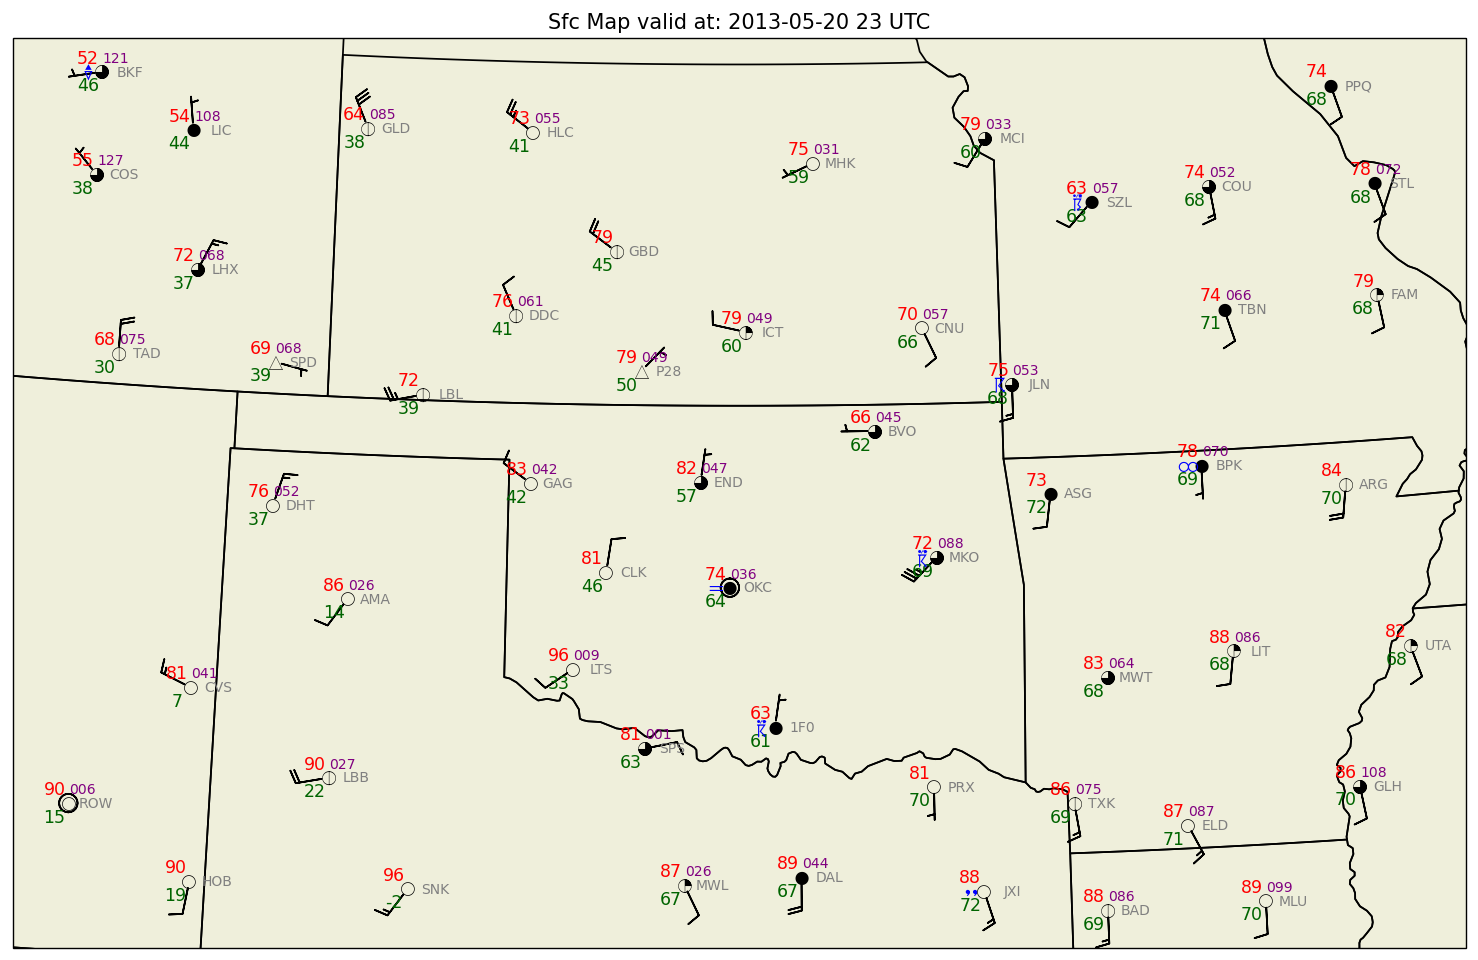

In [111]:
# Set up a plot with map features
# First set dpi ("dots per inch") - higher values will give us a less pixelated final figure.
dpi = 125

fig = plt.figure(figsize=(15,10), dpi=dpi)

proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_facecolor(cfeature.COLORS['water'])

land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
lake_mask = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
state_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                         scale='50m', facecolor='none')

ax.add_feature(land_mask)
ax.add_feature(lake_mask)
ax.add_feature(state_borders, linestyle='solid', edgecolor='black')

# Slightly reduce the extent of the map as compared to the subsetted data region; this helps eliminate data from being plotted beyond the frame of the map
ax.set_extent ((lonW,lonE,latS,latN), crs=ccrs.PlateCarree())


#If we wanted to add grid lines to our plot:
#ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=8)

stationplot.plot_parameter('NW', tair[mask], color='red', fontsize=10)
stationplot.plot_parameter('SW', dewp[mask], color='darkgreen', fontsize=10)

# Below, we are using a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp[mask], color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])



stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
stationplot.plot_symbol('W', wnum[mask], current_weather,color='blue',fontsize=12)
stationplot.plot_text((2, 0),stid[mask], color='gray')
#zorder - Higher value zorder will plot the variable on top of lower value zorder. This is necessary for wind barbs to appear. Default is 1.
stationplot.plot_barb(u[mask], v[mask],zorder=2)

plt.title("Sfc Map valid at: "+ timeStr)
plt.savefig (timeStr2 + '_sfmap.png',dpi=dpi)

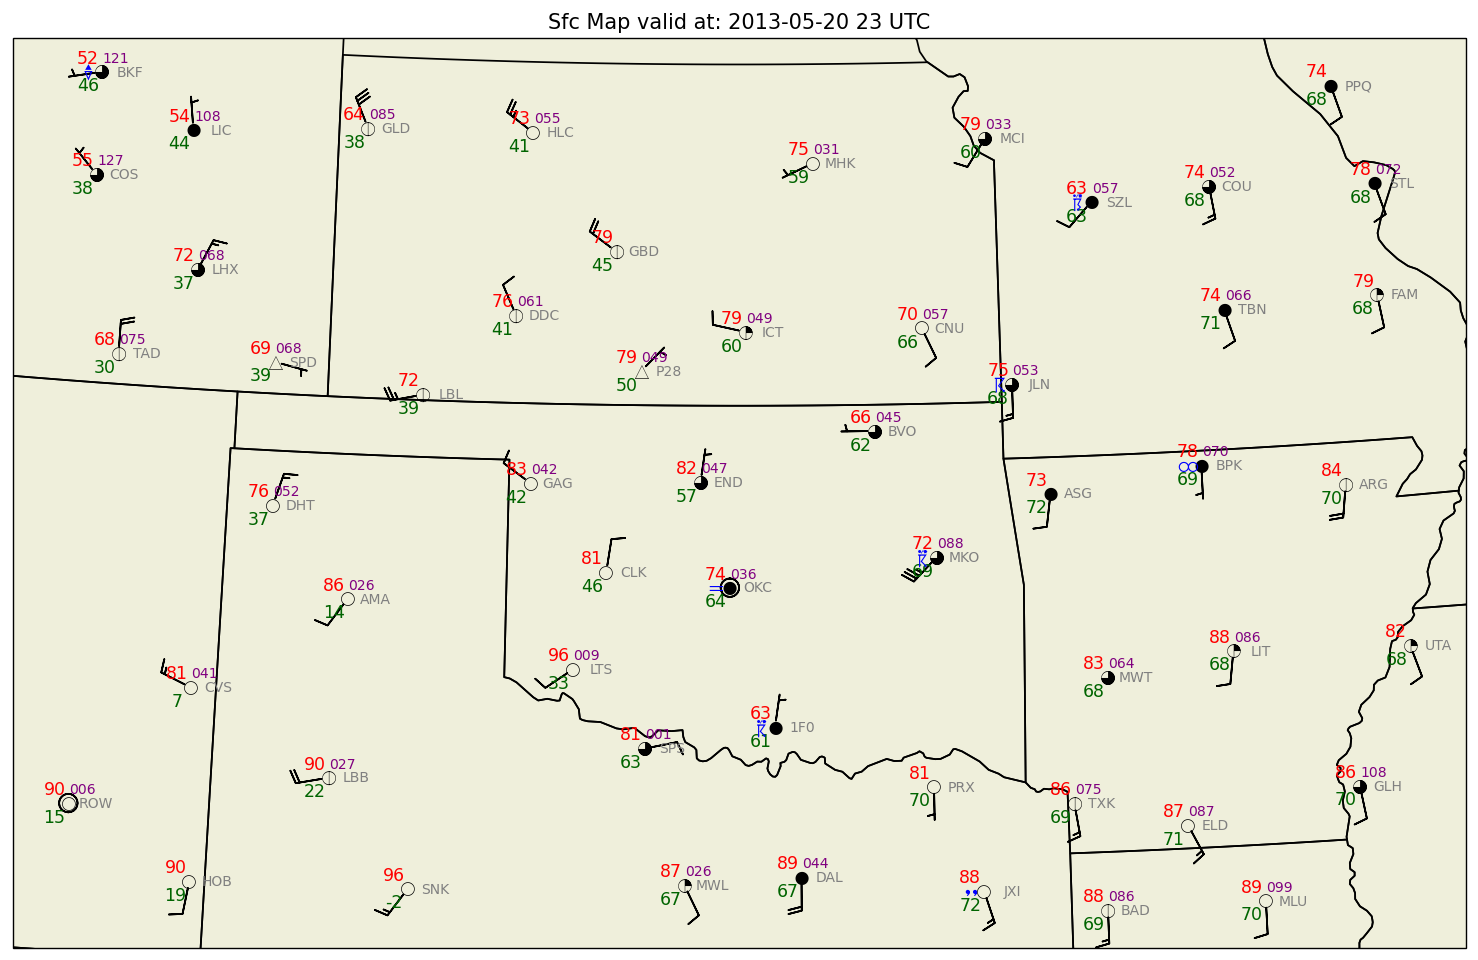

In [112]:
# In order to see the entire figure, type the name of the figure object below.
fig